# Standard Processing for UED Data Analysis

1. __Import all images__
    * Function called `gued.get_image_details` is used to load in all .tif files in the specified folder of interest. The function returns the images as a 3D data array, a 1D array of stage positions, file order, and total counts per image.

2. __Reject images with bad total counts__
    * Function called `gued.remove_counts` loads in the returns from `gued.get_image_details` and removes any images based on their total counts then returns the inputs with bad images removed.

3. __Subtract background__
    * The function called `gued.remove_background_pool` takes in a 3D array containing all image files and runs the hidden function `_remove_background` which creates a background image based on the corners of the original image. Then can either return the interpolated backgrounds or the cleaned data.
    * In cases where background images are taken as part of the experiment, use the `subtract_background` function with the data array and an average background image.

4. __Remove outlier instances of identical pixels__
    * This is generally referred to as removing x-ray hits or hot pixels. When working with large data sets, use the `gued.remove_xrays_pool` function. This function takes the 3D data array and runs the hidden function `_remove_xrays` in parallel. The function looks for instances of outlier pixels with respect to the average pixel value for all data. Returns the original data array with hot pixel values replaced with `np.nan`.

5. __Mask detector hole__
    * The function `gued.apply_mask` uses the `gued.mask_generator_alg` function to create a mask of `np.nan` values based on center and set radius. Returns masked data. Has the capability to apply multiple masks.

6. __Calculate diffraction center__
    * The function `gued.find_center_pool` runs the function `gued.find_center_alg` in parallel to find the center of all images. The pool function speeds up the process significantly but with small data sets can run `gued.find_center_alg` directly.

7. __Remove radial outliers__
    * The function `gued.remove_radial_outliers_pool` uses the hidden function `gued._preprocess_radial_data` which converts the data to polar coordinates, creates an interpolated average image from radial averages, then looks for instances of radial outliers and replaces them with `np.nan`.
    * This is by far the most time-consuming part of data processing. __Only do this with small data sets (i.e., after stage averaging) unless you're willing to spend a long time processing data.__ Takes 10 minutes per 100 images running in parallel.

8. __Apply median filter__
    * The function `gued.median_filter` applies a median filter to the data. Must replace `np.nan` values with radial average so this function is done in concert with the radial outlier removal (need to finalize).

9. __Retrieve Azimuthal Average__
    * The function `gued.azimuthal_average` takes the 3D data array and returns the azimuthal average for each data set.


## Global Variable Usage
The package gued relies on a few global variables which should be optimized for each experiment. The global variables are stored in gued_globals.py and follow standard formatting of all caps (i.e., CENTER_GUESS = (470, 450)). 

## Import Packages

In [17]:
import numpy as np
import GUED as gued 
import glob 
import time

## Import all images

Path to images  C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\nitrophenyl code\20180823\*\*\ANDOR1_*.tif
Path to background images  \work\centurion\shared\UED_data\FY18_o-nitrophenol\20180823\Background\*\*\ANDOR1_*.tif
Number of files loaded:  185
Number of background files loaded:  0
Load diffraction signal


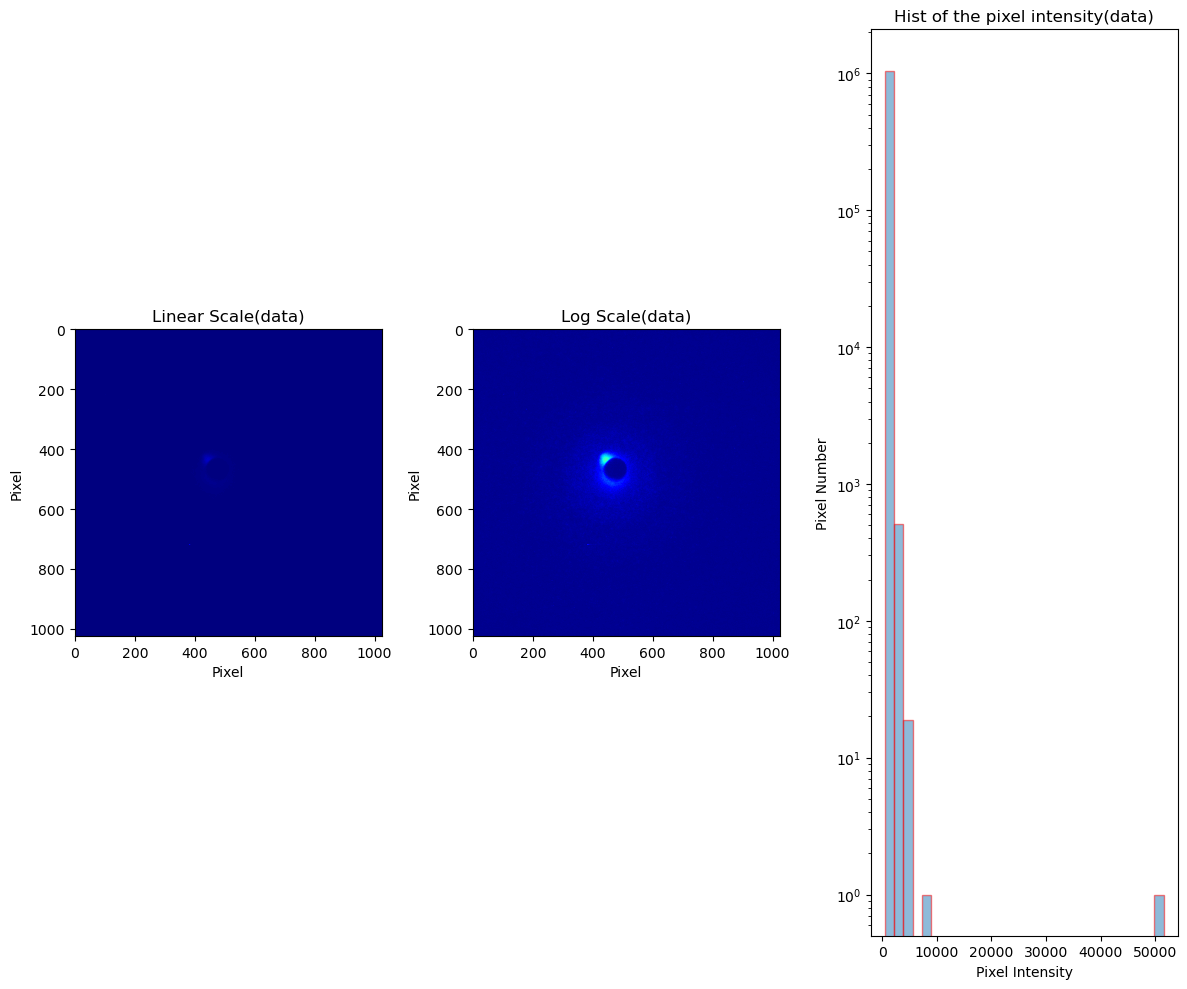

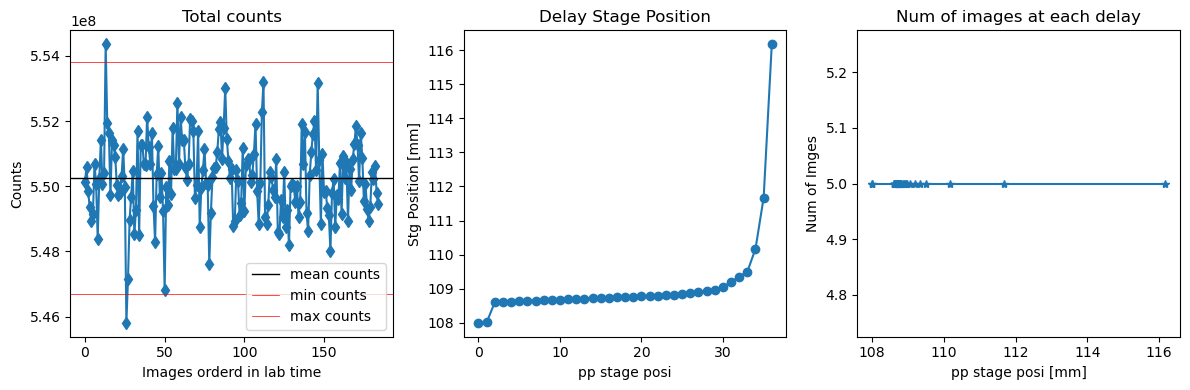

Image number read:  185
Stage positions:  37
185


In [6]:
dataPath = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\nitrophenyl code\\20180823'
runPath = "\\*\\*\\ANDOR1_*.tif"

bkg_path = '\\work\\centurion\\shared\\UED_data\\FY18_o-nitrophenol\\20180823\\Background\\*\\*\\ANDOR1_*.tif'

newPath = dataPath + runPath
print("Path to images ", newPath)
print("Path to background images ", bkg_path)

files = glob.glob(newPath)
bkg_files = glob.glob(bkg_path)
print("Number of files loaded: ", len(files))
print("Number of background files loaded: ", len(bkg_files))


print('Load diffraction signal');
data_array, stage_positions, file_order, counts = gued.get_image_details(files[:], sort=True, plot=True, filter_data=False)

counts_mean = np.mean(counts)        # Mean values of Total Counts of all images
counts_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position


print('Image number read: ', len(counts))
print('Stage positions: ', len(uni_stage))
print(len(np.unique(file_order)))

## Remove Images with Bad Counts

1  number of files removed from  183  initial files


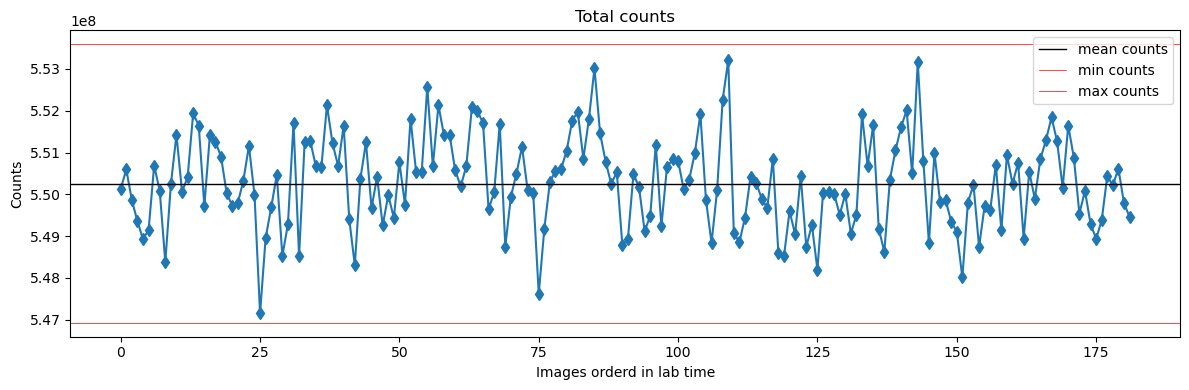

In [5]:
# Remove Outlier Images Based on Total Counts
data_array, stage_positions, file_order, counts = gued.remove_counts(data_array, stage_positions, file_order, counts, plot=True)


## Subtract Background

In [18]:
data_array = gued.remove_background_pool(data_array, plot=True)

TypeError: 'generator' object is not subscriptable